# Experimenting with different models to create food classifcation app

Dataset used in this project: https://pytorch.org/vision/stable/generated/torchvision.datasets.Food101.html

Note that data is reduced to 3 classes for simplicity of the experimenting

In [3]:
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cuda'

In [4]:
import torch
from torch import nn
from torchvision import datasets

from pathlib import Path

data_path = Path("data/")

train_dir = data_path / "pizza_steak_sushi/train"
test_dir = data_path / "pizza_steak_sushi/test"

In [5]:
train_dir

PosixPath('data/pizza_steak_sushi/train')

# Check Data(Images)

Image height: 512
Image width: 512


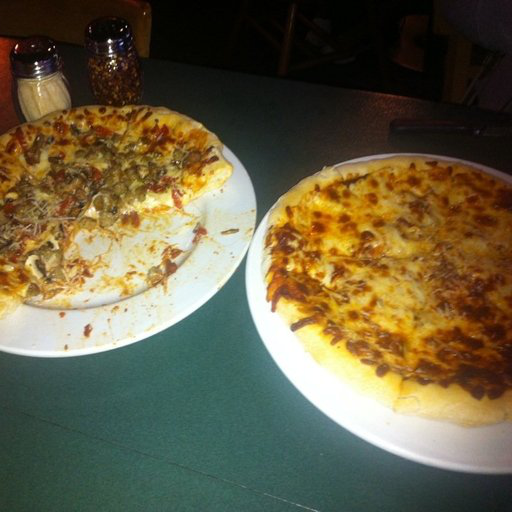

In [6]:
from PIL import Image

img_path = train_dir/ "pizza/1008844.jpg"
img = Image.open(img_path)

print(f"Image height: {img.height}") 
print(f"Image width: {img.width}")
img

# Load Data

In [7]:
import data_loader
from torchvision import datasets, transforms

data_transform = transforms.Compose([
  transforms.Resize((128, 128)),
  transforms.ToTensor()
])

train_dataloader, test_dataloader, class_names = data_loader.create_dataloaders(
    train_dir=train_dir,
    test_dir=test_dir,
    transform=data_transform,
    batch_size=32
)

In [8]:
len(train_dataloader), len(test_dataloader) #batches

(15, 5)

#Load Models

In [9]:
from models import ModelV1, ModelV2, ModelV3, ModelV4, ModelV1B, ModelV2B, ModelV3B, ModelV4B

models = []

model1 = ModelV1()
models.append(model1)

model2 = ModelV2()
models.append(model2)
model3 = ModelV3()
models.append(model3)
model4 = ModelV4()
models.append(model4)
model1b = ModelV1B()
models.append(model1b)
model2b = ModelV2B()
models.append(model2b)
model3b = ModelV3B()
models.append(model3b)
model4b = ModelV4B()
models.append(model4b)

model1

ModelV1(
  (conv_block_1): Sequential(
    (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1))
    (1): ReLU()
    (2): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (classifier): Sequential(
    (0): Flatten(start_dim=1, end_dim=-1)
    (1): Linear(in_features=123008, out_features=3, bias=True)
  )
)

In [10]:
models

[ModelV1(
   (conv_block_1): Sequential(
     (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1))
     (1): ReLU()
     (2): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1))
     (3): ReLU()
     (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
   )
   (classifier): Sequential(
     (0): Flatten(start_dim=1, end_dim=-1)
     (1): Linear(in_features=123008, out_features=3, bias=True)
   )
 ), ModelV2(
   (conv_block_1): Sequential(
     (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1))
     (1): ReLU()
     (2): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1))
     (3): ReLU()
     (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
   )
   (conv_block_2): Sequential(
     (0): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1))
     (1): ReLU()
     (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1))
     (3): ReLU()
     (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
   )
   (classifie

In [11]:
#Forward pass through untrained models

img_batch, label_batch = next(iter(train_dataloader))
img_single, label_single = img_batch[0].unsqueeze(dim=0), label_batch[0]
print(f"Single image shape: {img_single.shape}\n")

model1.eval()
with torch.inference_mode():
    pred = model1(img_single)

Single image shape: torch.Size([1, 3, 128, 128])



# Train models

In [12]:
from torch.optim import Adam
from torch.optim import SGD

from flow import train

results=[]

EPOCHS = 5

for model in models:
  loss_fn = nn.CrossEntropyLoss()
  optimizer = Adam(model.parameters(),0.001)

  result = train(model, train_dataloader,test_dataloader,optimizer,loss_fn,EPOCHS)

  results.append(result)

  print(f"Model trained: {model.__class__.__name__}")


Model trained: ModelV1
Model trained: ModelV2
Model trained: ModelV3
Model trained: ModelV4
Model trained: ModelV1B
Model trained: ModelV2B
Model trained: ModelV3B
Model trained: ModelV4B


# Evaluate

In [49]:
import matplotlib.pyplot as plt

def plot_curves_for_different_models(results, models, name):
  plt.figure(figsize=(16,8))

  for i in range(8): # 8 models
    plt.plot(results[i][name],label=f"{models[i].__class__.__name__}")
    
  plt.legend()

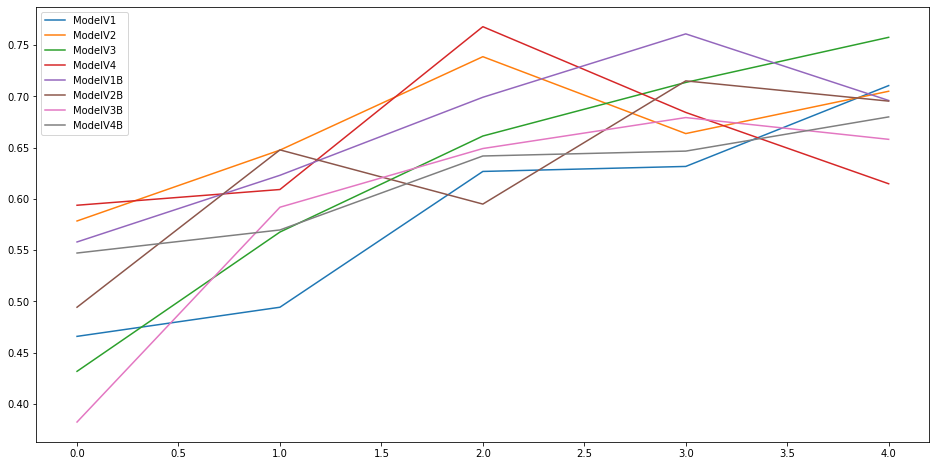

In [51]:
plot_curves_for_different_models(results,models,"test_acc")

In [63]:
def plot_all_data(results, models):
   plt.figure(figsize=(16,25))
   plt.subplot(4,1,1)
   for i in range(8): # 8 models
    plt.plot(results[i]["train_loss"],label=f"{models[i].__class__.__name__}")

   plt.title("train loss")
    
   plt.legend()

   plt.subplot(4,1,2)

   for i in range(8): # 8 models
    plt.plot(results[i]["train_acc"],label=f"{models[i].__class__.__name__}")
  
   plt.title("train acc")
   
   plt.subplot(4,1,3)
   for i in range(8): # 8 models
    plt.plot(results[i]["test_loss"],label=f"{models[i].__class__.__name__}")
   
   plt.title("test loss")

   plt.subplot(4,1,4)
   for i in range(8): # 8 models
    plt.plot(results[i]["test_acc"],label=f"{models[i].__class__.__name__}")

   plt.title("test acc")
   




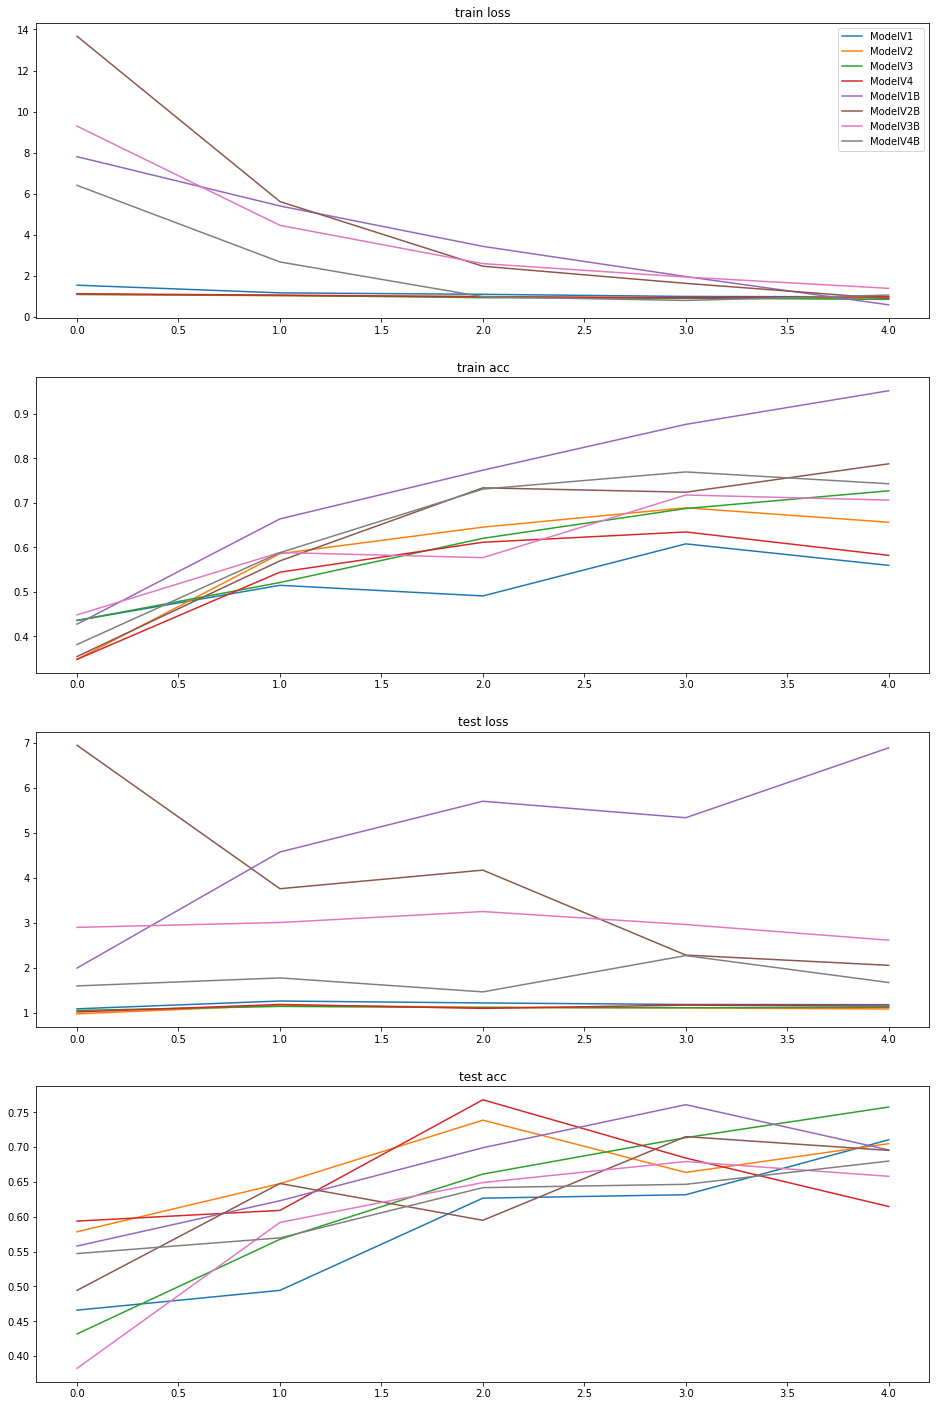

In [64]:
plot_all_data(results,models)

In [97]:
best_model = models[2] # ModelV3

img_batch, label_batch = next(iter(test_dataloader))
img_single, label_single = img_batch[0].unsqueeze(dim=0), label_batch[0]
print(f"Single image shape: {img_single.shape}\n")

model1.eval()
with torch.inference_mode():
    pred = model1(img_single)

    predicition = torch.softmax(pred.squeeze(), dim=0)

class_pred  = predicition.argmax()
class_pred, label_single

Single image shape: torch.Size([1, 3, 128, 128])



(tensor(1), tensor(1))

Class name: steak  , Predicted Label: steak


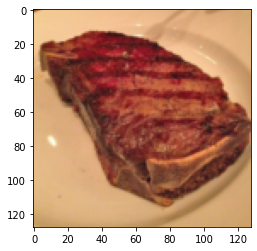

In [98]:
img_single = torch.squeeze(img_single,0)
img = img_single.permute(1,2,0)

print(f"Class name: {class_names[label_single]}  , Predicted Label: {class_names[class_pred]}")
plt.imshow(img)

# Save Model

In [99]:
from pathlib import Path

MODEL_PATH = Path("models")
MODEL_PATH.mkdir(parents=True,
                 exist_ok=True
)

MODEL_NAME = "Best_ModelV3.pth"
MODEL_SAVE_PATH = MODEL_PATH / MODEL_NAME

torch.save(obj=best_model.state_dict(), f=MODEL_SAVE_PATH)